# MSM UTIL

In [52]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
from pandas import DataFrame as df
from numpy import matlib
from scipy.optimize import fminbound, minimize, fsolve
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from datetime import date
#import winsound
from pylab import rcParams
import pickle
from datetime import date
from time import time

## T_mat_temp

In [35]:
def T_mat_temp(kbar):
    """
    Build template for kbar
    :param kbar:
    :return:
    """
#     kbar = int(kbar)
    A = np.fromfunction(lambda i, j: i ^ j, (2**kbar, 2**kbar), dtype=int)
    A_temp = A.astype(float)
    return A_temp

## MSM_starting_values(data, startingvals, kbar):

In [54]:
def MSM_starting_values(data, startingvals, kbar, distribution, dof, send_out):
    """
    find starting values for params
    :param data:
    :param startingvals:
    :param kbar:
    :return:
    """

    # print('No starting values entered: Using grid-search')
    # A grid search used to find the best set of starting values in the
    # event none are supplied by the user
    
    if bool(startingvals):
        dum = startingvals[1]
        b = [1.5, 1.5 + (dum-1.5)/3, 1.5 + 2*(dum-1.5)/3, dum]
        lb = len(b)
        
        dum = startingvals[2]
        g = [dum, (0.99-dum)/2+dum, .99]
        lg = len(g)
        sigma = startingvals[3]
        
    else :
        b = [1.5, 3, 6, 20]
        lb = len(b)
        g = [.1, .5, .99]
        lg = len(g)
        sigma = np.std(data, ddof=1) #* np.sqrt(252)
            
        
    

    LL_storage = df(columns=['LL', 'b', 'g', 'm','sigma'])
    m0_lower = 1.2
    m0_upper = 1.8

    index = 1

    # I know that adding one by one row on DF is quiet inefficient
    # I will try to use lambda, map instead of double for loop if I have a time

    for i in range(0, lb):
        for j in range(0, lg):
            a_m0 = fminbound(MSM_likelihood_new, 1.2, 1.8,
                             args=( b[i], g[j], sigma, kbar, data, distribution, dof, send_out), 
                             xtol=1e-05, maxfun=500, full_output=True)  # , disp=3)
            LL_storage.loc[len(LL_storage), 'LL'] = a_m0[1]
            LL_storage.loc[len(LL_storage) - 1, 'b'] = b[i]
            LL_storage.loc[len(LL_storage) - 1, 'g'] = g[j]
            LL_storage.loc[len(LL_storage) - 1, 'm'] = a_m0[0]

    LL_storage = LL_storage.sort_values(by=['LL'], ascending=True)
    LL_storage = LL_storage.reset_index(drop=True)
#     print(LL_storage)
    startingvals = [0., 0., 0., sigma]
    startingvals[1] = LL_storage.loc[0, 'b']
    startingvals[0] = LL_storage.loc[0, 'm']
    startingvals[2] = LL_storage.loc[0, 'g']

    return startingvals, LL_storage

## MSM_likelihood_new(*args):

In [53]:
def MSM_likelihood_new(*args, distribution = 'Normal', dof = 2, send_out = 'vol'):
    """
    calculate LL for 3 cases (depend on number of input)
    :param args:
    :return:
    """

    if len(args) ==6 :
        # optimize -> minimizer
#         print("len arg =3")
        inp = args[0]
        kbar = args[1]
        data = args[2]
        m0 = inp['m0'].value
        b = inp['b'].value
        gamma_k = inp['gamma_k'].value
        sigma = inp['sigma'].value
        distribution = args[3]
        dof = args[4]
        sendout = args[5]
        

    elif len(args) == 9 :
        # choose starting val -> fminbound
#         print("len arg =9")
        m0 = args[0]
        b = args[1]
        gamma_k = args[2]
        sigma = args[3]
        kbar = args[4]
        data = args[5]
        distribution = args[6]
        dof = args[7]
        sendout = args[8]

    elif len(args) == 4 :
        # for outcome
#         print("len arg =4")
        inp = args[0]
        kbar = args[1]
        data = args[2]
        m0 = inp['m0'].value
        b = inp['b'].value
        gamma_k = inp['gamma_k'].value
        sigma = inp['sigma'].value

    A_temp = T_mat_temp(kbar)
    k2 = 2 ** kbar
#     print("kbar = "+str(kbar))

    def transition_mat(A_temp, b, gamma_k, kbar):
        A = A_temp

        gamma = np.zeros((kbar, 1))
        gamma[0] = 1 - (1 - gamma_k) ** (1 / (b ** (kbar - 1)))

        def bitget(number, position):

            bi_number = bin(number)
            bi_number = bi_number[2:]
            if len(bi_number) >= position:

                fn_output = bi_number[-position]
            else:
                fn_output = 0

            return fn_output

        for i in range(1, kbar):
            gamma[i, 0] = 1 - (1 - gamma[0]) ** (b ** i)

        gamma = gamma / 2
        gamma = np.append(gamma, gamma, axis=1)
        gamma[:, 0] = 1 - gamma[:, 0]
        
         #print(gamma[:,1])
         #print(gamma[-1,1])

        kbar1 = kbar + 1
        kbar2 = 2 ** kbar

        prob = np.ones((kbar2, 1))

        for i in range(0, kbar2):
            for m in range(1, kbar + 1):
                prob[i, 0] = prob[i, 0] * gamma[kbar1 - m - 1, int(bitget(i, m))]

        for i in range(0, 2 ** (kbar - 1)):
            for j in range(i, 2 ** (kbar - 1)):
                A[kbar2 - i - 1, j] = prob[kbar2 - int(A[i, j]) - 1, 0]
                A[kbar2 - j - 1, i] = A[kbar2 - i - 1, j]
                A[j, kbar2 - i - 1] = A[kbar2 - i - 1, j]
                A[i, kbar2 - j - 1] = A[kbar2 - i - 1, j]

                A[i, j] = prob[int(A[i, j]), 0]
                A[j, i] = A[i, j]
                A[kbar2 - i - 1, kbar2 - j - 1] = A[i, j]
                A[kbar2 - j - 1, kbar2 - i - 1] = A[i, j]
        return A, gamma

    def gofm(m0, kbar):

        m1 = 2 - m0
        kbar2 = 2 ** kbar
        g_m1 = list(range(0, kbar2))
        for i in range(0, kbar2):
            g = 1
            for j in range(0, kbar):  # not req -1
                if g_m1[i] & 2 ** j != 0:
                    g = g * m1
                else:
                    g = g * m0
            g_m1[i] = g

        g_m = np.sqrt(g_m1)
        return g_m

    A, gamma = transition_mat(A_temp, b, gamma_k, kbar)
    g_m = gofm(m0, kbar)
    T = len(data)
    pi_mat = np.zeros((T + 1, k2))
    LLs = np.zeros((T,1))
    pi_mat[0, :] = (1 / k2) * np.ones((1, k2))

    # Likelihood Algorithm

    pa = (2 * np.pi) ** (-0.5)

    # g_m is binomial measure ?
    g_m = np.array(g_m).reshape((1, len(g_m)))
    s = np.matlib.repmat(sigma * g_m, T, 1)


    data2 = np.array(data).reshape((len(data), 1))
    
    if distribution == 'Normal':
        w_t = np.matlib.repmat(data2, 1, k2)
        w_t = np.divide(pa * np.e ** (-0.5 * np.power(np.divide(w_t, s), 2)), s)
        w_t = w_t + 10 ** -16
    elif distribution == 'ChiSq':
        w_t = np.matlib.repmat(data2, 1, k2)
        w_t = chi2.pdf(w_t, dof)
        w_t = w_t + 10 ** -16

    for t in range(0, T):
        piA = np.matmul(pi_mat[t, :], A)
        C = np.multiply(w_t[t, :], piA)
        ft = sum(C)

        # stop div by zero if prob are too low
        if ft == 0:
            pi_mat[t + 1, :] = (1 / k2) * np.ones((1, k2))
            print("!!!!!")
        else:
            pi_mat[t + 1, :] = np.divide(C, ft)

        LLs[t] = np.log(np.dot(w_t[t, :], piA))

    LL = -sum(LLs)

    if np.isinf(LL):
        print('Log-likelihood is inf. Probably due to all zeros in pi_mat.')

    if (len(args) == 4) & (send_out == 'vol'):
        # Volatility prediction (single state)
        
        t_predict = args[3]
        vol = np.ones((t_predict,1))
        vol = vol.astype(float)
        state_now = pi_mat[-1 , :]
        
        for t in range(0,t_predict):
            vol[t,0] = sum(np.matmul(state_now, np.linalg.matrix_power(A, t+1)))*sigma
        
        return vol
    
    elif (len(args) == 4) & (send_out == 'forecast multistep'):
        # get state for multiple forecast time 
        
        return pi_mat, A, sigma, s
        
    else:
        return sum(LL)#+1/(2*gamma[-1,1])-1

## MSM_fitdata(data, kbar, LB ,UB, op_methods, startingvals):

In [38]:
def MSM_fitdata(data, kbar, LB ,UB, op_methods, startingvals, distribution , dof , send_out):
    """
    Combine MSM_likelihood_new, MSM_starting_values, T_mat_Temp
    :param data: Must be a column vector of a log return
    from latest day [index0 : 1 Jan 1974] to today [index -1 : 1 Jan 2018]
    multiply it with 100
    :param kbar:
    :param LB:
    :param UB:
    :param op_methods:
    :param startingvals:
    :return:
    """

    input_param, LLS = MSM_starting_values(data, startingvals, kbar, distribution, dof, send_out)
        # print('LL = %8.4f' % LLS.loc[0, 'LL'])
        
     #input_param = startingvals
    
    # create a set of Parameters
    params = Parameters()
    params.add('m0', value=input_param[0], min=LB[0], max=UB[0])
    params.add('b', value=input_param[1], min=LB[1], max=UB[1])
    params.add('gamma_k', input_param[2], min=LB[2], max=UB[2])
    params.add('sigma', value=input_param[3], min=LB[3], max=UB[3])

#     print("==========init params=========")
#     for element in params:
#         print(element + " = %8.4f" % (params[element].value))



    minner = Minimizer(MSM_likelihood_new, params, fcn_args=(kbar, data, distribution , dof , send_out))
    result = minner.minimize(method=op_methods)
    

#     print("\n\n ==========fitted results==========")
#     print('optimization method = ' + op_methods)
#     for element in result.params:
#         print(element + " = %8.4f" % (result.params[element].value))
#     print("\n")
    # print('LLs = %8.4f' % (result.residual))
    # print('AIC = %8.4f' % (result.aic))
    # print('BIC = %8.4f' % (result.bic))

    return result

## msm_fitseries(data, kbar, LB, UB, op_methods, startingvals, m, RV):
    

In [11]:
def msm_fitseries(data, kbar, LB, UB, op_methods, startingvals, m, RV):
    """
     series of MSM_fitdata for calculate step-by-step
    :param data: 
    :param kbar: 
    :param LB: 
    :param UB: 
    :param op_methods: OPTIMIZATION METHOD
    :param startingvals: 
    :param m: numbers of days we try to estimate
    :param RV: days to calculate RV
    :return: 
    """
    output = df()
    output["RV"] = []
    output["m0"] = []
    output["b"] = []
    output["gamma_k"] = []
    output["sigma"] = []

    for i in range(0, m):
        print("round" + str(i))
        data2 = data[i:len(data) - m + i]
        result = MSM_fitdata(data2, kbar, LB, UB, op_methods, startingvals)
        re2 = MSM_likelihood_new(result.params, kbar, data2, RV)
        output.loc[i, "RV"] = sum(re2) ** 2 * 100
        for element in result.params:
            output.loc[i, element] = result.params[element].value

    return output

## msm_averageparams(output, kbar, m, data, RV, LB , UB):
    

In [12]:
def msm_averageparams(output, kbar, m, data, RV, LB , UB):
    """
    AVERAGE INPUT PARAMS for test robutness of model
    :param output:
    :param kbar:
    :param m:
    :param data:
    :param RV:
    :param LB:
    :param UB:
    :return:
    """
    mean_o = output.mean()
    params = Parameters()
    params.add('m0', value=mean_o[1], min=LB[0], max=UB[0])
    params.add('b', value=mean_o[2], min=LB[1], max=UB[1])
    params.add('gamma_k', mean_o[3], min=LB[2], max=UB[2])
    params.add('sigma', value=mean_o[4], min=LB[3], max=UB[3])

    output_m = df()
    output_m["RV"] = []
    output_m["m0"] = []
    output_m["b"] = []
    output_m["gamma_k"] = []
    output_m["sigma"] = []

    for i in range(0, m):
        data2 = data[i:len(data) - m + i]
        re2 = MSM_likelihood_new(params, kbar, data2, RV)
        output_m.loc[i, "RV"] = sum(re2) ** 2 * 100
        for element in params:
            output_m.loc[i, element] = params[element].value

    return output_m

## msm_plot

In [13]:
def msm_plot(GVZ, output, m):
    """
    plot quickly
    :param GVZ:
    :param output:
    :param m:
    :return:
    """

    # GVZ = xls_data['GVZ']
    GVZ_lastm = GVZ[::-1]
    GVZ_lastm = GVZ_lastm.iloc[-m:]

    plt.figure()
    actual = plt.plot(range(0, m), GVZ_lastm, label='GVZ', color='red')
    model = plt.plot(range(0, m), (output['RV']), label='MSM')

    plt.title('Predict VOL actual(GVZ) vs forecast(model)')
    plt.legend()

    plt.figure()
    plt.plot(range(0, m), output['m0'], label='m0')
    plt.title('m0')
    plt.legend()

    plt.figure()
    plt.plot(range(0, m), output['b'], label='b')
    plt.title('b')
    plt.legend()

    plt.figure()
    plt.plot(range(0, m), output['gamma_k'], label='gamma_k')
    plt.title('gamma_k')
    plt.legend()

    plt.figure()
    plt.plot(range(0, m), output['gamma_k'], label='gamma_k')
    plt.title('gamma_k')
    plt.legend()

    plt.figure()
    plt.plot(range(0, m), output['sigma'], label='sigma')
    plt.title('sigma')
    plt.legend()

    plt.show()

## linreg(x,y)

In [14]:
def linreg(x,y):
    """
    Quick Regression
    :param x:
    :param y:
    :return:
    """
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(x, y)

    # The coefficients
    print('Slope : ', sum(sum(regr.coef_)))
    print('Intercept : ', sum(regr.intercept_))

    # # The mean squared error
    # print("Mean squared error: %.2f"
    #       % mean_squared_error(diabetes_y_test, diabetes_y_pred))
    # # Explained variance score: 1 is perfect prediction
    # print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

    return sum(sum(regr.coef_)), sum(regr.intercept_)

## msm_vary_k_cal(data, vary, kbar_start, kbar_max, LB, UB, op_methods, startingvals, m, RVn):
    

In [15]:
def msm_vary_k_cal(data, vary, kbar_start, kbar_max, LB, UB, op_methods, startingvals, m, RVn):
    """
    calculation by vary kbar to see the effect of kbar
    :param data:
    :param vary: "k"
    :param kbar_start:
    :param kbar_max:
    :param LB:
    :param UB:
    :param op_methods:
    :param startingvals:
    :param m:
    :param RVn:
    :return:
    """
    RV = df()
    m0 = df()
    b = df()
    gamma_k = df()
    sigma = df()

    for kbar in range(kbar_start, kbar_max):
        # fit series
        print("=====kbar = " + str(kbar))
        output = msm_fitseries(data, kbar, LB, UB, op_methods, startingvals, m, RVn)
        RV[vary + str(kbar)] = output["RV"]
        m0[vary + str(kbar)] = output["m0"]
        b[vary + str(kbar)] = output["b"]
        gamma_k[vary + str(kbar)] = output["gamma_k"]
        sigma[vary + str(kbar)] = output["sigma"]

    text = 'MSM_vary_kbar'
    namew = text + str(kbar_max) + "_RV" + str(RVn) + '_m' + str(m) + ".xlsx"
    writer = pd.ExcelWriter("".join((date.today().strftime('%y%m%d'), namew)))
    RV.to_excel(writer, 'RV')
    m0.to_excel(writer, 'm0')
    b.to_excel(writer, 'b')
    gamma_k.to_excel(writer, 'gamma_k')
    sigma.to_excel(writer, 'sigma')
    print("".join((date.today().strftime('%y%m%d'), namew)))
    writer.save()

    #frequency = 2500  # Set Frequency To 2500 Hertz
    #duration = 1000  # Set Duration To 1000 ms == 1 second
    #winsound.Beep(frequency, duration)

    return RV, m0, b, gamma_k, sigma

## msm_vary_k_plot(GVZ, m=20, *args):


In [16]:
def msm_vary_k_plot(GVZ, m=20, *args):

    def label_plot(m, x, LA):
        for LAs in LA:
            plt.plot(range(0, m), x[LAs], label=LAs)

    if len(args) == 1:
        xls = pd.ExcelFile(args[0])
        RV = pd.read_excel(xls, 'RV')
        m0 = pd.read_excel(xls, 'm0')
        b = pd.read_excel(xls, 'b')
        gamma_k = pd.read_excel(xls, 'gamma_k')
        sigma = pd.read_excel(xls, 'sigma')

    elif len(args) == 5:
        RV = args[0]
        m0 = args[1]
        b = args[2]
        gamma_k = args[3]
        sigma = args[4]

    GVZ_lastm = GVZ.iloc[-m:]

    rcParams['figure.figsize'] = 5, 25

    LA = m0.columns.tolist()

    plt.subplot(511)
    actual = plt.plot(range(0, m), GVZ_lastm, label='GVZ', color='red')
    label_plot(m, RV, LA)
    plt.title('Predict VOL actual(GVZ) vs forecast(model)')
    plt.legend()

    plt.subplot(512)
    label_plot(m, m0, LA)
    plt.title('m0')
    plt.legend()

    plt.subplot(513)
    label_plot(m, b, LA)
    plt.title('b')
    plt.legend()

    plt.subplot(514)
    label_plot(m, gamma_k, LA)
    plt.title('gamma_k')
    plt.legend()

    plt.subplot(515)
    label_plot(m, sigma, LA)
    plt.title('sigma')
    plt.legend()

    plt.show()

## MSM_likelihood_wantto_forecast

In [17]:
def MSM_likelihood_wantto_forecast(*args,**kwargs):
    """
    calculate LL for 3 cases (depend on number of input)
    :param args:
    :return:
    """
    if kwargs is None:
        distribution = 'Normal'
        
    if len(args) ==3 :
        # choose starting val
        inp = args[0]
        kbar = args[1]
        data = args[2]
        m0 = inp['m0'].value
        b = inp['b'].value
        gamma_k = inp['gamma_k'].value
        sigma = inp['sigma'].value

    elif len(args) == 4 :
        # prediction
        inp = args[0]
        kbar = args[1]
        data = args[2]
        m0 = inp['m0'].value
        b = inp['b'].value
        gamma_k = inp['gamma_k'].value
        sigma = inp['sigma'].value
        

    A_temp = T_mat_temp(kbar)
    k2 = 2 ** kbar

    def transition_mat(A_temp, b, gamma_k, kbar):
        A = A_temp

        gamma = np.zeros((kbar, 1))
        gamma[0] = 1 - (1 - gamma_k) ** (1 / (b ** (kbar - 1)))

        def bitget(number, position):

            bi_number = bin(number)
            bi_number = bi_number[2:]
            if len(bi_number) >= position:

                fn_output = bi_number[-position]
            else:
                fn_output = 0

            return fn_output

        for i in range(1, kbar):
            gamma[i, 0] = 1 - (1 - gamma[0]) ** (b ** i)

        gamma = gamma / 2
        gamma = np.append(gamma, gamma, axis=1)
        gamma[:, 0] = 1 - gamma[:, 0]

        kbar1 = kbar + 1
        kbar2 = 2 ** kbar

        prob = np.ones((kbar2, 1))

        for i in range(0, kbar2):
            for m in range(1, kbar + 1):
                prob[i, 0] = prob[i, 0] * gamma[kbar1 - m - 1, int(bitget(i, m))]

        for i in range(0, 2 ** (kbar - 1)):
            for j in range(i, 2 ** (kbar - 1)):
                A[kbar2 - i - 1, j] = prob[kbar2 - int(A[i, j]) - 1, 0]
                A[kbar2 - j - 1, i] = A[kbar2 - i - 1, j]
                A[j, kbar2 - i - 1] = A[kbar2 - i - 1, j]
                A[i, kbar2 - j - 1] = A[kbar2 - i - 1, j]

                A[i, j] = prob[int(A[i, j]), 0]
                A[j, i] = A[i, j]
                A[kbar2 - i - 1, kbar2 - j - 1] = A[i, j]
                A[kbar2 - j - 1, kbar2 - i - 1] = A[i, j]
        return A

    def gofm(m0, kbar):

        m1 = 2 - m0
        kbar2 = 2 ** kbar
        g_m1 = list(range(0, kbar2))
        for i in range(0, kbar2):
            g = 1
            for j in range(0, kbar):  # not req -1
                if g_m1[i] & 2 ** j != 0:
                    g = g * m1
                else:
                    g = g * m0
            g_m1[i] = g

        g_m = np.sqrt(g_m1)
        return g_m

    A = transition_mat(A_temp, b, gamma_k, kbar)
    g_m = gofm(m0, kbar)
    T = len(data)
    pi_mat = np.zeros((T + 1, k2))
    LLs = np.zeros((T,1))
    pi_mat[0, :] = (1 / k2) * np.ones((1, k2))

    # Likelihood Algorithm

    pa = (2 * np.pi) ** (-0.5)

    # g_m is binomial measure ?
    g_m = np.array(g_m).reshape((1, len(g_m)))
    s = np.matlib.repmat(sigma * g_m, T, 1)


    data2 = np.array(data).reshape((len(data), 1))
    
    if distribution == 'Normal':
        w_t = np.matlib.repmat(data2, 1, k2)
        w_t = np.divide(pa * np.e ** (-0.5 * np.power(np.divide(w_t, s), 2)), s)
        w_t = w_t + 10 ** -16
    elif distribution == 'ChiSq':
        w_t = np.matlib.repmat(data2, 1, k2)
        w_t = np.divide(pa * np.e ** (-0.5 * np.power(np.divide(w_t, s), 2)), s)
        w_t = w_t + 10 ** -16

    for t in range(0, T):
        piA = np.matmul(pi_mat[t, :], A)
        C = np.multiply(w_t[t, :], piA)
        ft = sum(C)

        # stop div by zero if prob are too low
        if ft == 0:
            pi_mat[t + 1, :] = (1 / k2) * np.ones((1, k2))
            print("!!!!!")
        else:
            pi_mat[t + 1, :] = np.divide(C, ft)

        LLs[t] = np.log(np.dot(w_t[t, :], piA))

    LL = -sum(LLs)

    if np.isinf(LL):
        print('Log-likelihood is inf. Probably due to all zeros in pi_mat.')

    if len(args) == 4:

        # provide ingrdents for forecast
        
        return pi_mat, A, sigma, s

    else:
        return sum(LL)

# TEST FIT_PARAMS

## INPUT

In [15]:
filename = 'fed_data.xlsx'
xls = pd.ExcelFile(filename)
CA_raw = pd.read_excel(xls, 'CA')
DM_raw = pd.read_excel(xls, 'DM')
JA_raw = pd.read_excel(xls, 'JA')
UK_raw = pd.read_excel(xls, 'UK')

### construct a reaw data matrix

In [16]:
def T3(dum_data, Table3_Currency_Vol, row):
    returns = 100*np.log(1+dum_data['Column2'].pct_change().dropna())
    subperiod = 4
    Table3_Currency_Vol.loc[row,'Entire'] = float(np.std(returns))
    for i in range(0,subperiod):
        sub_data = dum_data['Column2']
        #print('i = ' + str(i))
        #print('from : ',int(np.floor(i*len(returns)/subperiod)))
        #print('to   : ',int(np.floor((i+1)*len(returns)/subperiod)))
        sub_data = sub_data.iloc[int(np.floor(i*len(returns)/subperiod)):int(np.floor((i+1)*len(returns)/subperiod))]
        returns2 = 100*np.log(1+sub_data.pct_change().dropna())
        Table3_Currency_Vol.iloc[row,i+1] = float(np.std(returns2))
        
    return Table3_Currency_Vol


In [17]:
Table3_Currency_Vol = df()
Table3_Currency_Vol['Entire']=[]
Table3_Currency_Vol['Sub1']=[]
Table3_Currency_Vol['Sub2']=[]
Table3_Currency_Vol['Sub3']=[]
Table3_Currency_Vol['Sub4']=[]

raw = [DM_raw, JA_raw, UK_raw, CA_raw]
for row in range(0, len(raw)):
    Table3_Currency_Vol = T3(raw[row], Table3_Currency_Vol, row)
Table3_Currency_Vol

,Entire,Sub1,Sub2,Sub3,Sub4
0,0.664101,0.586819,0.716642,0.708206,0.635449
1,0.656566,0.544619,0.639886,0.645119,0.775137
2,0.606847,0.485806,0.724471,0.699407,0.472817
3,0.274376,0.220132,0.254553,0.284356,0.326698


### plot to see data

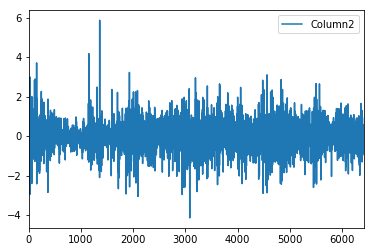

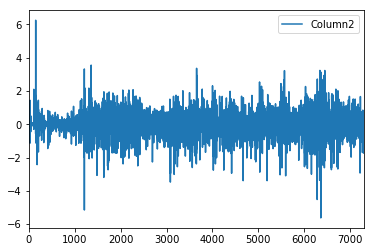

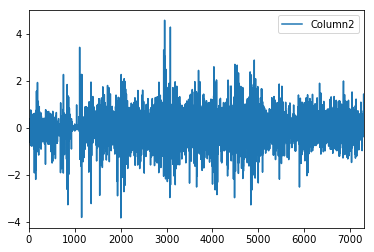

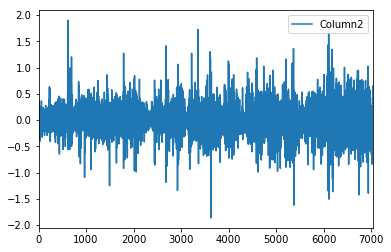

In [18]:
# rcParams['figure.figsize'] = 5, 10

for row in range(0, len(raw)):
    dum_data = raw[row]
    returns = 100*np.log(1+dum_data['Column2'].pct_change().dropna())
    a = returns.to_frame()
    a.plot()

plt.show()

## OUTPUT

#### Construct a output dataframe for store hard working parameters

In [19]:
output = df()
output["m0"] = []
output["b"] = []
output["gamma_k"]=[]
output["sigma"] = []
output["LL"] = []
result = []

startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]

### DM

In [63]:
op_methods = 'slsqp'
row = 0
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
data2 = data#[::-1]
startingvals = []

for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data, kbar, LB ,UB,op_methods, startingvals)
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data2)
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value
        
writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+'DMvaryk.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()
        
output  

         LL    b     g        m sigma
0   5924.15  1.5   0.1  1.66418   NaN
1   5924.15    3   0.1  1.66418   NaN
2   5924.15    6   0.1  1.66418   NaN
3   5924.15   20   0.1  1.66418   NaN
4   6029.55  1.5   0.5  1.74141   NaN
5   6029.55    3   0.5  1.74141   NaN
6   6029.55    6   0.5  1.74141   NaN
7   6029.55   20   0.5  1.74141   NaN
8   6135.42  1.5  0.99  1.73377   NaN
9   6135.42    3  0.99  1.73377   NaN
10  6135.42    6  0.99  1.73377   NaN
11  6135.42   20  0.99  1.73377   NaN
==========init params=========
m0 =   1.6642
b =   1.5000
gamma_k =   0.1000
sigma =   0.6642


 ==========fitted results==========
optimization method = slsqp
m0 =   1.6541
b =   1.5000
gamma_k =   0.0747
sigma =   0.6819


         LL    b          g        m sigma
0   5794.83  1.5  0.0747172  1.57793   NaN
1   5794.83  1.5  0.0747172  1.57793   NaN
2   5794.83  1.5  0.0747172  1.57793   NaN
3   5794.83  1.5  0.0747172  1.57793   NaN
4   5959.69  1.5   0.532359  1.62232   NaN
5   5959.69  1.5   0.53

,m0,b,gamma_k,sigma,LL
0,1.654133,1.500000,0.074717,0.681917,5920.855214
1,1.589895,8.016456,0.106826,0.650560,5782.955933
2,1.554623,21.914346,0.672529,0.600255,5731.776138
3,1.491546,10.420285,0.713536,0.571605,5715.300200
4,1.461936,7.886674,0.750633,0.511672,5708.240226
5,1.412923,5.160288,0.858273,0.537734,5706.903687
6,1.379843,4.117634,0.931533,0.546732,5704.470829
7,1.352666,3.381746,0.973716,0.550389,5704.765369
8,1.330602,2.850096,0.972934,0.560066,5705.342737
9,1.325676,2.702472,0.958863,0.643250,5705.085364


### JPY

In [64]:
op_methods = 'slsqp'
row = 1
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
data2 = data#[::-1]
startingvals = []

for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data, kbar, LB ,UB,op_methods, startingvals)
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data2)
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value
        
writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+'JPYvaryk.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()
        
output  

         LL    b     g        m sigma
0   6474.43  1.5   0.1  1.75145   NaN
1   6474.43    3   0.1  1.75145   NaN
2   6474.43    6   0.1  1.75145   NaN
3   6474.43   20   0.1  1.75145   NaN
4   6506.28  1.5   0.5  1.79999   NaN
5   6506.28    3   0.5  1.79999   NaN
6   6506.28    6   0.5  1.79999   NaN
7   6506.28   20   0.5  1.79999   NaN
8   6657.16  1.5  0.99  1.79999   NaN
9   6657.16    3  0.99  1.79999   NaN
10  6657.16    6  0.99  1.79999   NaN
11  6657.16   20  0.99  1.79999   NaN
==========init params=========
m0 =   1.7514
b =   1.5000
gamma_k =   0.1000
sigma =   0.6566


 ==========fitted results==========
optimization method = slsqp
m0 =   1.7969
b =   1.5000
gamma_k =   0.1989
sigma =   0.6298


         LL    b         g        m sigma
0   6198.81  1.5  0.198939  1.71102   NaN
1   6198.81  1.5  0.198939  1.71102   NaN
2   6198.81  1.5  0.198939  1.71102   NaN
3   6198.81  1.5  0.198939  1.71102   NaN
4   6368.15  1.5  0.594469  1.71573   NaN
5   6368.15  1.5  0.594469  1

,m0,b,gamma_k,sigma,LL
0,1.796889,1.500000,0.198939,0.629831,6451.792036
1,1.776111,50.000000,0.326086,0.542971,6106.053752
2,1.693020,12.457074,0.311943,0.565602,5959.710137
3,1.654031,15.584963,0.697383,0.461888,5900.663844
4,1.586325,8.717936,0.869250,0.464081,5883.238714
5,1.534078,6.296554,0.956450,0.466958,5875.473759
6,1.527624,6.006854,0.966087,0.391437,5870.013921
7,1.512750,5.649653,0.974797,0.513890,5863.189012
8,1.475161,4.430843,0.995420,0.486330,5862.997348
9,1.448112,3.761698,0.997645,0.461049,5862.674907


### GBP

In [61]:
kbar >1 and bool([])

False

In [89]:
op_methods = 'slsqp'
row = 2
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
data2 = data#[::-1]
startingvals = []


for i in range(0,10):
    kbar = i+1
    print(kbar)
    
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    
    result = MSM_fitdata(data, kbar, LB ,UB,op_methods, startingvals)
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data2)
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value
        
writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+'GBPvaryk5.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()
        
output  

1
         LL    b     g        m sigma
0   5960.39  1.5   0.1  1.71092   NaN
1   5960.39    3   0.1  1.71092   NaN
2   5960.39    6   0.1  1.71092   NaN
3   5960.39   20   0.1  1.71092   NaN
4   6042.08  1.5   0.5  1.79291   NaN
5   6042.08    3   0.5  1.79291   NaN
6   6042.08    6   0.5  1.79291   NaN
7   6042.08   20   0.5  1.79291   NaN
8   6195.76  1.5  0.99  1.78486   NaN
9   6195.76    3  0.99  1.78486   NaN
10  6195.76    6  0.99  1.78486   NaN
11  6195.76   20  0.99  1.78486   NaN
==========init params=========
m0 =   1.7109
b =   1.5000
gamma_k =   0.1000
sigma =   0.6069


 ==========fitted results==========
optimization method = slsqp
m0 =   1.7157
b =   1.5000
gamma_k =   0.1099
sigma =   0.6087


2
         LL    b         g        m sigma
0   5766.16  1.5  0.109946  1.65469   NaN
1   5766.16  1.5  0.109946  1.65469   NaN
2   5766.16  1.5  0.109946  1.65469   NaN
3   5766.16  1.5  0.109946  1.65469   NaN
4   5938.49  1.5  0.549973  1.67616   NaN
5   5938.49  1.5  0.54997

,m0,b,gamma_k,sigma,LL
0,1.715749,1.500000,0.109946,0.608671,5960.169424
1,1.671453,19.905125,0.222162,0.589502,5724.358738
2,1.647739,14.286373,0.277987,0.513368,5622.725978
3,1.609153,12.506440,0.644940,0.467186,5570.014433
4,1.578921,11.017527,0.637128,0.421256,5537.792457
5,1.533702,8.315625,0.783474,0.467635,5523.628778
6,1.503309,6.715476,0.811321,0.389147,5516.877211
7,1.460527,5.232527,0.958404,0.383777,5515.366208
8,1.428160,4.075240,0.964411,0.373594,5515.268775
9,1.402960,3.450710,0.981753,0.370389,5514.933868


### CAD

In [90]:
op_methods = 'slsqp'
row = 3
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
data2 = data#[::-1]
startingvals = []

for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data, kbar, LB ,UB,op_methods, startingvals)
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data2)
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value

writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+'CADvaryk.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()

output  

         LL    b     g        m sigma
0   277.435  1.5   0.1  1.66057   NaN
1   277.435    3   0.1  1.66057   NaN
2   277.435    6   0.1  1.66057   NaN
3   277.435   20   0.1  1.66057   NaN
4   422.325  1.5   0.5  1.71418   NaN
5   422.325    3   0.5  1.71418   NaN
6   422.325    6   0.5  1.71418   NaN
7   422.325   20   0.5  1.71418   NaN
8   550.776  1.5  0.99  1.69648   NaN
9   550.776    3  0.99  1.69648   NaN
10  550.776    6  0.99  1.69648   NaN
11  550.776   20  0.99  1.69648   NaN
==========init params=========
m0 =   1.6606
b =   1.5000
gamma_k =   0.1000
sigma =   0.2744


 ==========fitted results==========
optimization method = lbgfsb
m0 =   1.6459
b =   1.8901
gamma_k =   0.0638
sigma =   0.2799


         LL        b         g        m sigma
0   143.498  1.89008  0.063751  1.54284   NaN
1   144.306  1.76005  0.063751  1.54288   NaN
2   145.193  1.63003  0.063751  1.54297   NaN
3   146.169      1.5  0.063751  1.54314   NaN
4   331.158  1.89008  0.526876  1.58396   NaN
5   

,m0,b,gamma_k,sigma,LL
0,1.645898,1.890077,0.063751,0.279945,271.002919
1,1.555995,10.924122,0.109383,0.277510,129.793835
2,1.473888,4.758877,0.128981,0.292861,105.152252
3,1.435084,3.948461,0.170709,0.263496,91.314827
4,1.386468,4.022594,0.441384,0.251030,88.401337
5,1.373756,4.075756,0.523879,0.294691,84.719261
6,1.337553,3.111044,0.593339,0.281890,84.022924
7,1.319242,2.723327,0.594994,0.262433,83.389001
8,1.295804,2.350653,0.630917,0.259362,83.046985
9,1.277733,2.108387,0.643876,0.261617,82.989752


## export set of params to .xlsx

In [82]:
output

,m0,b,gamma_k,sigma,LL
0,1.724131,1.500000,0.129090,0.608754,5967.526625
1,1.673841,21.302960,0.245566,0.587575,5727.634096
2,1.649398,15.651842,0.324070,0.508946,5625.049883
3,1.609224,12.765558,0.659629,0.467231,5570.547290
4,1.579176,11.205719,0.650867,0.420608,5538.345034
5,1.533688,8.403110,0.792995,0.467599,5523.897339
6,1.585299,49.864345,0.956547,0.294231,5563.227019
7,1.609050,44.049004,0.392482,0.471145,5586.177678
8,1.460462,5.237711,0.959639,0.522382,5515.864436
9,1.402961,3.450525,0.981728,0.370388,5514.933868


In [81]:
name = 'GBP'
name_L = 'Output'.join((date.today().strftime('%y%m%d'),op_methods+name+'5.xlsx'))
writer = pd.ExcelWriter(name_L)
print(name_L)
output.to_excel(writer, 'Sheet1')
writer.save()

180218OutputslsqpGBP5.xlsx


# Verify likelihood function

In [26]:
op_methods = 'lbfgsb'
row = 1
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
returns = returns
a = returns.to_frame()
data = a['Column2']

MSM_likelihood_new(1.782,134.2,0.345,0.538, 2, data*100)

6102.1694666264148

# Fit data

## FIT for forecast

In [39]:
row = 0
op_methods = 'slsqp'
predict_period = 1
kbar = 10

starting_index = 3000
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]
startingvals = []
data_fit = data[:starting_index]

# fit params

result = MSM_fitdata(data_fit, kbar, LB ,UB,op_methods, startingvals)
#re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data_fit)
rez = result.params

KeyboardInterrupt: 

### Chain forecast

In [52]:
row = 3
op_methods = 'slsqp'
predict_period = 1

starting_index = 3000
dum_data = raw[row]
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]
startingvals = []
data_fit = data[:starting_index]

# fit params

for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data_fit, kbar, LB ,UB,op_methods, startingvals)
    rez = result.params
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,
                             result.params['sigma'].value,  kbar, data_fit
                            )
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value

         LL    b     g        m sigma
0  -350.937  1.5   0.1  1.66302   NaN
1  -350.937    3   0.1  1.66302   NaN
2  -350.937    6   0.1  1.66302   NaN
3  -350.937   20   0.1  1.66302   NaN
4  -279.652  1.5   0.5  1.71289   NaN
5  -279.652    3   0.5  1.71289   NaN
6  -279.652    6   0.5  1.71289   NaN
7  -279.652   20   0.5  1.71289   NaN
8  -213.158  1.5  0.99  1.69334   NaN
9  -213.158    3  0.99  1.69334   NaN
10 -213.158    6  0.99  1.69334   NaN
11 -213.158   20  0.99  1.69334   NaN
==========init params=========
m0 =   1.6630
b =   1.5000
gamma_k =   0.1000
sigma =   0.2372


 ==========fitted results==========
optimization method = slsqp
m0 =   1.6694
b =   1.5000
gamma_k =   0.0720
sigma =   0.2572


         LL    b         g        m sigma
0  -421.009  1.5  0.072032  1.54328   NaN
1  -421.009  1.5  0.072032  1.54328   NaN
2  -421.009  1.5  0.072032  1.54328   NaN
3  -421.009  1.5  0.072032  1.54328   NaN
4  -318.226  1.5  0.531016  1.60865   NaN
5  -318.226  1.5  0.531016  1

In [53]:
pi_mat, A, sigma, s = MSM_likelihood_wantto_forecast(rez, kbar, data, predict_period)

## PICKLE for import/export model

### save

In [54]:
import pickle
from datetime import date
# obj0, obj1, obj2 are created here...

data_name = 'DM'
model_name = ''.join((date.today().strftime('%y%m%d'),"_"+ str(kbar)+ op_methods+ str(data_name) + '.pkl'))
# Saving the objects:
with open(model_name, 'wb') as f: 
    pickle.dump(result.params, f)
    print(model_name)


180225_10slsqpDM.pkl


### load

In [61]:
import pickle
# # Getting back the objects:
with open('180219_10slsqpDM.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    rez_2 = pickle.load(f)

In [65]:
rez

In [63]:
rez_2

Parameters([('m0', <Parameter 'm0', 1.6299929540997213, bounds=[1:1.99]>),
            ('b', <Parameter 'b', 4.4117265184781624, bounds=[1:50]>),
            ('gamma_k',
             <Parameter 'gamma_k', 0.70285396272487677, bounds=[0.001:0.99999]>),
            ('sigma',
             <Parameter 'sigma', 0.58279795462479345, bounds=[0.0001:50]>)])

## forecast process 1 day 

In [55]:
# df for OLS
Pdict = df()
Pdict["vol"] = []
predict_period = 1

vol = np.ones((predict_period,1))
vol = vol.astype(float)
for i in range(starting_index,len(pi_mat)-1):
    
    state_now = pi_mat[i , :]
    for t in range(0,predict_period):
        vol[t,0] = np.inner(np.matmul(state_now, np.linalg.matrix_power(A, t+1)),s[1,:])
    Pdict.loc[i,"vol"] = sum(vol)

In [56]:
returns = np.log(1+dum_data['Column2'].pct_change().dropna())
a = returns.to_frame()
data = a['Column2']*100
rsq = data[starting_index-2:].shift(-predict_period)
dfrsq = rsq.to_frame()
Pdict['real']=dfrsq**2
Pdict

,vol,real
3000,0.263898,0.238701
3001,0.303271,0.003385
3002,0.278490,0.005282
3003,0.256471,0.053919
3004,0.256532,0.480795
3005,0.342735,0.063307
3006,0.325556,0.000206
3007,0.295745,0.000000
3008,0.268269,0.070364
3009,0.272440,0.082254


In [36]:
rsq = data[starting_index-2:]**2
rsq

2999    0.127299
3000    0.001578
3001    0.311108
3002    1.419519
3003    0.303802
3004    0.954062
3005    0.434004
3006    2.071969
3007    2.371633
3008    1.316507
3009    0.055844
3010    0.759151
3011    0.177033
3012    0.110339
3013    0.014044
3014    1.389559
3015    0.006108
3016    2.407529
3017    0.331438
3018    5.251678
3019    0.620733
3020    0.000000
3021    0.024187
3022    1.013223
3023    0.214667
3024    1.810096
3025    0.118497
3026    0.005876
3027    0.442175
3028    1.173901
          ...   
7269    0.057591
7270    0.009201
7271    0.018822
7272    0.020750
7273    0.091236
7274    0.048297
7275    0.078888
7276    0.015181
7277    0.141379
7278    0.041991
7279    0.000421
7280    0.013533
7281    0.045148
7282    0.016974
7283    0.005678
7284    0.001687
7285    0.269198
7286    0.016716
7287    0.000740
7288    0.031190
7289    0.101417
7290    0.336519
7291    0.001131
7292    0.533191
7293    0.001113
7294    0.210995
7295    0.143872
7296    2.0821

## Regression

### stats model

In [57]:
import statsmodels.api as sm

print('dataset = %1.0f' %row)

for ele in rez:
    print(ele,' = %8.4f'  %rez[ele].value)
x = Pdict.loc[:,'vol'].values.reshape(len(Pdict),1)
y = Pdict['real']

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())
# print("MODEL MSE",est2.mse_model)
print("MODEL MSE",est2.mse_resid)
print("MODEL TSE",est2.mse_total)

dataset = 3
m0  =   1.2766
b  =   1.5693
gamma_k  =   0.2899
sigma  =   0.2345
                            OLS Regression Results                            
Dep. Variable:                   real   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     185.1
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           3.05e-41
Time:                        14:45:08   Log-Likelihood:                 976.51
No. Observations:                4048   AIC:                            -1949.
Df Residuals:                    4046   BIC:                            -1936.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

## EXPORT Result!

In [126]:
# output = df()
# 

In [135]:
for element in result.params:
    output.loc[row,element] = result.params[element].value

output.loc[row,'Slope'] = sum(regr.coef_)
output.loc[row,'intercept'] =  regr.intercept_
output.loc[row,'MSE'] = mean_squared_error(y, x)
output.loc[row,'R_sq'] = r2_score(y, x)

writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),'ALL_REG.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()

In [112]:
result.params

Parameters([('m0', <Parameter 'm0', 1.629998096335135, bounds=[1:1.99]>),
            ('b', <Parameter 'b', 4.4120315416646161, bounds=[1:50]>),
            ('gamma_k',
             <Parameter 'gamma_k', 0.70287857197217063, bounds=[0.001:0.99999]>),
            ('sigma',
             <Parameter 'sigma', 0.58282108145794298, bounds=[0.0001:50]>)])

In [38]:
output

,m0,b,gamma_k,sigma,LL
0,1.856799,1.500000,0.151344,0.559417,2165.156704
1,1.790297,18.353692,0.223294,0.518750,1994.989617
2,1.760918,14.145956,0.332085,0.448827,1918.480683
3,1.704834,5.141529,0.170362,0.540188,1886.691143
4,1.636330,5.037106,0.384254,0.447685,1877.105656
5,1.600150,5.596331,0.688778,0.524212,1872.450342
6,1.559214,4.162739,0.673908,0.435483,1869.788388
7,1.512173,3.358684,0.800145,0.436961,1870.498799
8,1.484956,2.810734,0.792318,0.423587,1870.388228
9,1.456981,2.539776,0.838297,0.410643,1870.705819


# Gold Data

## input

In [44]:
GLD.loc[8000,:]

Date                                                                                                                 2000-01-02
Last Price                                                                                                               410,05
index                                                                                                                    410.05
log return                                                                                                            -0.148025
The Gold Spot price is quoted as US Dollars per Troy Ounce.  Type ALLQ <GO> for the list of price contributors                1
Name: 8000, dtype: object

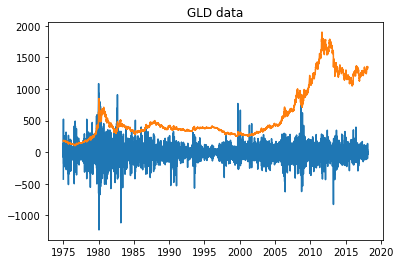

In [61]:
GVZ = pd.read_excel('Data_GVZ_GLD_long.xlsx','GVZ')
GLD = pd.read_excel('Data_GVZ_GLD_long.xlsx','GLD')

GLD_r = GLD.loc[:,'log return'].dropna()
GLD_date = GLD.loc[:,'Date'].dropna()
GLD_data = GLD.loc[:,'index'].dropna()

plt.plot(GLD_date.iloc[:-1],200*GLD_r)
plt.plot(GLD_date,GLD_data)
plt.title('GLD data')


data = GLD_r[::-1]
data = data.reset_index(drop = True)
plt.show()

## output 

In [56]:
output = df()
output["m0"] = []
output["b"] = []
output["gamma_k"]=[]
output["sigma"] = []
output["LL"] = []
result = []

startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]

In [62]:
data = data[3000:]

## Fit data

In [64]:
op_methods = 'slsqp'
data2 = data#[::-1]
startingvals = []

for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data, kbar, LB ,UB,op_methods, startingvals)
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value,  kbar, data2)
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value
        
writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+'GLDvaryk.xlsx')))
output.to_excel(writer, 'Sheet1')
writer.save()
        
output

KeyboardInterrupt: 

# GLD Forecast

### drop index 

In [67]:
GVZ_date = GVZ_date[0:999]

In [66]:
GVZ_date = GVZ.loc[:,'Date'].dropna()
GVZ_data = GVZ.loc[:,'index'].dropna()
GLD_date = GLD.loc[:,'Date'].dropna()
GLD_data = GLD.loc[:,'index'].dropna()

# GVZ/GLD use for regression (new -> old)
GVZ_date = GVZ_date.drop(GVZ_date.index[0])
GVZ_date = GVZ_date.reset_index(drop=True)
# for small date
GVZ_date = GVZ_date[0:1000]
GVZ_data = GVZ_data.reset_index(drop=True)

GLD_data = GLD_data.drop(GLD_date.index[0])
GLD_data = GLD_data.reset_index(drop=True)
GLD_date = GLD_date.drop(GLD_date.index[0])
GLD_date = GLD_date.drop(GLD_date.index[len(GLD_date)-1])
GLD_date = GLD_date.reset_index(drop=True)

# all to df
df_reg = GVZ_date.to_frame()
df_reg["GVZ"] = GVZ_data
df_reg["GLD"] = GLD_data

# [old -> new]
df_reg = df_reg[::-1]
# df_reg

# New data drop the first (last date) because there are no GVZ data
# data use for MSM function (old -> new)
data = GLD_r
data = data.drop(data.index[len(data)-1])
data = data.reset_index(drop=True)
data_fit = data.drop(data.index[0:len(df_reg)])


## chain forecast

### param

In [68]:
op_methods = 'slsqp'
predict_period = 1
kbar = 10
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]
startingvals = []

### fit param

In [69]:
# fit params
for i in range(0,10):
    kbar = i+1
    if kbar >1 and bool(result):
        startingvals = [result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,result.params['sigma'].value]
    result = MSM_fitdata(data_fit, kbar, LB ,UB,op_methods, startingvals)
    rez = result.params
    re2 = MSM_likelihood_new(result.params['m0'].value,result.params['b'].value,result.params['gamma_k'].value,
                             result.params['sigma'].value,  kbar, data_fit
                            )
    output.loc[i,"LL"] = re2
    for element in result.params:
        output.loc[i,element] = result.params[element].value

         LL    b     g        m sigma
0   6352.21  1.5   0.1  1.75295   NaN
1   6352.21    3   0.1  1.75295   NaN
2   6352.21    6   0.1  1.75295   NaN
3   6352.21   20   0.1  1.75295   NaN
4   6649.02  1.5   0.5  1.79999   NaN
5   6649.02    3   0.5  1.79999   NaN
6   6649.02    6   0.5  1.79999   NaN
7   6649.02   20   0.5  1.79999   NaN
8   6961.54  1.5  0.99  1.79999   NaN
9   6961.54    3  0.99  1.79999   NaN
10  6961.54    6  0.99  1.79999   NaN
11  6961.54   20  0.99  1.79999   NaN
==========init params=========
m0 =   1.7530
b =   1.5000
gamma_k =   0.1000
sigma =   0.5465


 ==========fitted results==========
optimization method = slsqp
m0 =   1.7737
b =   1.5000
gamma_k =   0.0470
sigma =   0.6649


         LL    b          g        m sigma
0   5891.15  1.5  0.0470288  1.66967   NaN
1   5891.15  1.5  0.0470288  1.66967   NaN
2   5891.15  1.5  0.0470288  1.66967   NaN
3   5891.15  1.5  0.0470288  1.66967   NaN
4   6335.53  1.5   0.518514  1.76591   NaN
5   6335.53  1.5   0.51

## save params

In [70]:
import pickle
from datetime import date
# obj0, obj1, obj2 are created here...

data_name = 'GLD'
model_name = ''.join((date.today().strftime('%y%m%d'),"_"+ str(kbar)+ op_methods+ str(data_name) + '.pkl'))
# Saving the objects:
with open(model_name, 'wb') as f: 
    pickle.dump(result.params, f)
    print(model_name)


180312_10slsqpGLD.pkl


### load params

In [33]:
import pickle
# # Getting back the objects:
kbar = 10
with open('180225_10slsqpGLD.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    rez_2 = pickle.load(f)

In [67]:
rez = rez_2

## get forecast params

In [71]:
predict_period = -1
pi_mat, A, sigma, s = MSM_likelihood_wantto_forecast(rez, kbar, data, predict_period)

## forecast 1 day

In [79]:
len(data2)

8056

In [78]:
len(data)

11055

In [72]:
# df for OLS
starting_index = len(data)-len(df_reg)
predict_period = 30
from time import time

t1 = time()
Pdict = df()
Pdict["vol"] = []
df_reg["vol"] = 0.


vol = np.ones((predict_period,1))
vol = vol.astype(float)
for i in range(starting_index+1,len(pi_mat)-1):
    state_now = pi_mat[i , :]
    for t in range(0,predict_period):
        vol[t,0] = np.inner(np.matmul(state_now, np.linalg.matrix_power(A, t+1)),s[1,:])
    df_reg.loc[len(pi_mat)-i-2,"vol"] = sum(vol)
print("TIME : %2.5f" %(time() - t1)) 
#     Pdict.loc[i,"vol"] = sum(vol)

TIME : 6005.96716


### save forcast data

In [73]:
name = 'GVZreg'+str(predict_period)
name_L = 'Output'.join((date.today().strftime('%y%m%d'),name+'.xlsx'))
writer = pd.ExcelWriter(name_L)
print(name_L)
df_reg.to_excel(writer, 'Sheet1')
writer.save()

180312OutputGVZreg30.xlsx


### load forecast data

In [34]:
filename = '180301OutputGVZreg30.xlsx' # '180310OutputGVZreg1.xlsx' 180312OutputGVZreg30.xlsx
xls = pd.ExcelFile(filename)
df_reg = pd.read_excel(xls)

## Regression

In [74]:
df_reg

,Date,GVZ,GLD,vol
999,2014-03-03,17.05,1289.80,0.000000
998,2014-03-04,16.75,1283.79,20.653213
997,2014-03-05,16.58,1283.90,21.828884
996,2014-03-06,16.31,1293.36,22.538794
995,2014-03-07,15.82,1303.20,22.662567
994,2014-03-10,15.83,1296.68,22.200353
993,2014-03-11,16.14,1295.90,21.314360
992,2014-03-12,16.67,1291.55,21.432773
991,2014-03-13,17.30,1284.30,22.259553
990,2014-03-14,18.32,1299.62,21.597977


In [77]:
df_reg

,Date,GVZ,GLD,vol
999,2014-03-03,17.05,1289.80,0.000000
998,2014-03-04,16.75,1283.79,20.653213
997,2014-03-05,16.58,1283.90,21.828884
996,2014-03-06,16.31,1293.36,22.538794
995,2014-03-07,15.82,1303.20,22.662567
994,2014-03-10,15.83,1296.68,22.200353
993,2014-03-11,16.14,1295.90,21.314360
992,2014-03-12,16.67,1291.55,21.432773
991,2014-03-13,17.30,1284.30,22.259553
990,2014-03-14,18.32,1299.62,21.597977


### y= mx +c ; y as GVZ

In [75]:
import statsmodels.api as sm

# print('dataset = %1.0f' %row)

for ele in rez:
    print(ele,' = %8.4f'  %rez[ele].value)

x = df_reg.loc[:,'vol'].values.reshape(len(df_reg),1)
y = df_reg['GVZ']

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())
# print("MODEL MSE",est2.mse_model)
print("MODEL MSE",est2.mse_resid)
print("MODEL TSE",est2.mse_total)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m0  =   1.3736
b  =   3.8084
gamma_k  =   0.9993
sigma  =   0.5718
                            OLS Regression Results                            
Dep. Variable:                    GVZ   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.259
Date:                Mon, 12 Mar 2018   Prob (F-statistic):             0.0125
Time:                        19:24:29   Log-Likelihood:                -2547.5
No. Observations:                1000   AIC:                             5099.
Df Residuals:                     998   BIC:                             5109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

### y= mx ; y as GVZ

In [76]:
est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())
print("MODEL MSE",est2.mse_resid)
print("MODEL TSE",est2.mse_total)

                            OLS Regression Results                            
Dep. Variable:                    GVZ   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 1.061e+04
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:24:29   Log-Likelihood:                -2972.0
No. Observations:                1000   AIC:                             5946.
Df Residuals:                     999   BIC:                             5951.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9938      0.010    103.029      0.0

### change y to realized vol

In [52]:
y = (np.log(1+df_reg["GLD"].pct_change().dropna())*100)**2

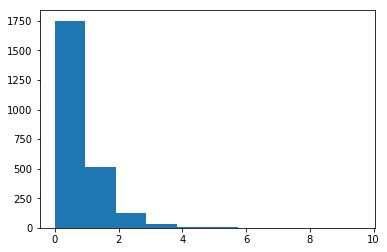

In [59]:
plt.hist(np.sqrt(y))
plt.show()

In [57]:
x = df_reg.loc[2443:,'vol'].values.reshape(len(df_reg)-1,1)

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())
# print("MODEL MSE",est2.mse_model)
print("MODEL MSE",est2.mse_resid)
print("MODEL TSE",est2.mse_total)

                            OLS Regression Results                            
Dep. Variable:                    GLD   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     365.2
Date:                Mon, 05 Mar 2018   Prob (F-statistic):           5.48e-76
Time:                        13:48:45   Log-Likelihood:                -6330.3
No. Observations:                2444   AIC:                         1.266e+04
Df Residuals:                    2442   BIC:                         1.268e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5028      0.255    -13.750      0.0

### reg y:realize x:1dayvol

In [75]:
df_reg

,Date,GVZ,GLD,vol
2444,2008-06-03,22.89,859.75,0.000000
2443,2008-06-04,22.69,887.10,0.296299
2442,2008-06-05,22.78,907.62,0.343200
2441,2008-06-06,23.60,913.25,0.383804
2440,2008-06-09,24.47,849.85,0.352073
2439,2008-06-10,25.39,833.05,0.370142
2438,2008-06-11,25.36,836.70,0.349232
2437,2008-06-12,25.04,846.90,0.427358
2436,2008-06-13,24.94,804.60,0.444245
2435,2008-06-16,24.98,783.35,0.409408


In [72]:
y = (np.log(1+df_reg["GLD"].pct_change().dropna())*100)**2

In [73]:
x = df_reg.loc[2443:,'vol'].values.reshape(len(df_reg)-1,1)

x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())
# print("MODEL MSE",est2.mse_model)
print("MODEL MSE",est2.mse_resid)
print("MODEL TSE",est2.mse_total)

                            OLS Regression Results                            
Dep. Variable:                    GLD   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.176
Date:                Mon, 05 Mar 2018   Prob (F-statistic):              0.278
Time:                        14:09:21   Log-Likelihood:                -6500.0
No. Observations:                2444   AIC:                         1.300e+04
Df Residuals:                    2442   BIC:                         1.302e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0216      0.182      5.624      0.0

> The result told me that I can't use MSM with Gold price processes.

REALLY?


In [16]:
Data

,Dates,GLD,GVZ,SPX,VIX,USO,OVX
0,1968-03-14,NaN,NaN,88.32,NaN,NaN,NaN
1,1968-03-15,NaN,NaN,89.10,NaN,NaN,NaN
2,1968-03-18,NaN,NaN,89.59,NaN,NaN,NaN
3,1968-03-19,NaN,NaN,88.99,NaN,NaN,NaN
4,1968-03-20,NaN,NaN,88.98,NaN,NaN,NaN
5,1968-03-21,NaN,NaN,88.33,NaN,NaN,NaN
6,1968-03-22,NaN,NaN,88.42,NaN,NaN,NaN
7,1968-03-25,NaN,NaN,88.33,NaN,NaN,NaN
8,1968-03-26,NaN,NaN,88.93,NaN,NaN,NaN
9,1968-03-27,NaN,NaN,89.66,NaN,NaN,NaN


13/03/2018


# IMPORT NEW DATA

## input

### read data

In [18]:
Data = pd.read_excel('all_3_data.xlsx','Sheet2')

In [14]:
Data

,Dates,GLD,GVZ,SPX,VIX,USO,OVX
0,1968-03-14,NaN,NaN,88.32,NaN,NaN,NaN
1,1968-03-15,NaN,NaN,89.10,NaN,NaN,NaN
2,1968-03-18,NaN,NaN,89.59,NaN,NaN,NaN
3,1968-03-19,NaN,NaN,88.99,NaN,NaN,NaN
4,1968-03-20,NaN,NaN,88.98,NaN,NaN,NaN
5,1968-03-21,NaN,NaN,88.33,NaN,NaN,NaN
6,1968-03-22,NaN,NaN,88.42,NaN,NaN,NaN
7,1968-03-25,NaN,NaN,88.33,NaN,NaN,NaN
8,1968-03-26,NaN,NaN,88.93,NaN,NaN,NaN
9,1968-03-27,NaN,NaN,89.66,NaN,NaN,NaN


### dynamic execution of Python code.

In [19]:
asset = ('GLD', 'GVZ', 'SPX', 'VIX', 'USO', 'OVX')
for i in range(0,len(asset)):
    exec( eval("asset["+str(i)+"]") +"= Data.loc[:,('Dates',"+"asset["+str(i)+"])]" )
    exec( eval("asset["+str(i)+"]") +"_r=100*np.log(1+"+ str(eval("asset["+str(i)+"]")+".iloc[:,1]")+".pct_change().dropna())" )
    exec( eval("asset["+str(i)+"]") +"="+ eval("asset["+str(i)+"]")+".dropna()" )

### plot

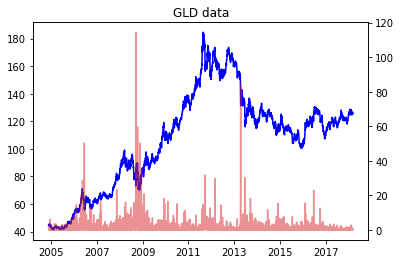

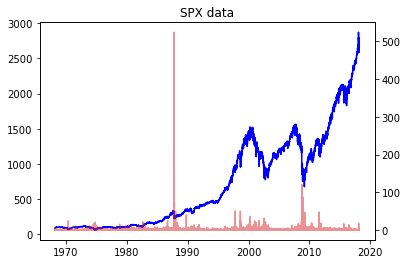

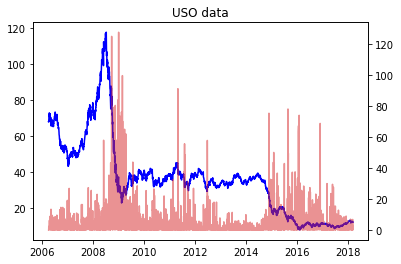

In [20]:
for i in (0,2,4):
    fig,ax1 = plt.subplots()
    eval("ax1.plot("+eval('''asset['''+str(i)+''']''')+".loc[:,'Dates'],"+eval('''asset['''+str(i)+''']''')+".iloc[:,1],'b-')")
    ax2 = ax1.twinx()
    eval("ax2.plot("+eval('''asset['''+str(i)+''']''')+".iloc[1:,0],"+eval('''asset['''+str(i)+''']''')+"_r**2,color = 'tab:red', alpha = 0.5)")
    plt.title(eval('''asset['''+str(i)+''']''')+' data')


# data = GLD_r[::-1]
# data = data.reset_index(drop = True)
plt.show()

## Fit data

In [44]:
for i in (0,2,4):
    name = eval('''asset['''+str(i)+''']''')
    exec( "data =" + eval('''asset['''+str(i)+''']''')+"_r" )
    distribution = "Normal"
    dof = 1 # for Chi**2 only
    send_out = "vol"
    
    output = df()
    output["m0"] = []
    output["b"] = []
    output["gamma_k"]=[]
    output["sigma"] = []
    output["LL"] = []
    result = []

    startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
    LB = [1, 1, 0.001, 0.0001]
    UB = [1.99, 50, 0.99999, 50]
    
    op_methods = 'slsqp'
    data2 = data

    for i in range(0,10):
        kbar = i+1
        if kbar >1 and bool(result):
            startingvals = [result.params['m0'].value,result.params['b'].value,
                            result.params['gamma_k'].value,result.params['sigma'].value]
        result = MSM_fitdata(data, kbar, LB, UB, op_methods, startingvals, distribution, dof, send_out)
         
        re2 = MSM_likelihood_new(result.params['m0'].value, result.params['b'].value,
                                 result.params['gamma_k'].value, result.params['sigma'].value, kbar, data2,
                                 distribution, dof, send_out)
        output.loc[i,"LL"] = re2
        for element in result.params:
            output.loc[i,element] = result.params[element].value
        
    writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),op_methods+name+'varyk.xlsx')))
    output.to_excel(writer, 'Sheet1')
    writer.save()
    

len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1
len arg =9
kbar = 1


len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2
len arg =3
kbar = 2


len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4
len arg =9
kbar = 4


len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5
len arg =3
kbar = 5


len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7
len arg =9
kbar = 7


ValueError: Objective function must return a scalar

# Forecast new 3 

## Train data

### drop index

In [31]:
GLD.iloc[-1000:,:]

,Dates,GLD
12044,2014-05-14,125.81
12045,2014-05-15,124.77
12046,2014-05-16,124.50
12047,2014-05-19,124.58
12048,2014-05-20,124.69
12049,2014-05-21,124.39
12050,2014-05-22,124.67
12051,2014-05-23,124.51
12052,2014-05-26,124.51
12053,2014-05-27,121.85


### run and save

In [50]:
for i in (0,2,4):
    
    # this step use partial data
    
    maxlen = 1000
    name = eval('''asset['''+str(i)+''']''')
    exec( "data =" + eval('''asset['''+str(i)+''']''')+"_r" )
    exec( "data_y =" + eval('''asset['''+str(i+1)+''']''') )
    
    if len(data_y) > maxlen :
        data_y = data_y.iloc[-maxlen:,1]
    else :
        data_y = data_y.iloc[:,1]

    data = data.iloc[:len(data)-len(data_y)]
            
    output = df()
    output["m0"] = []
    output["b"] = []
    output["gamma_k"]=[]
    output["sigma"] = []
    output["LL"] = []
    result = []

    startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
    LB = [1, 1, 0.001, 0.0001]
    UB = [1.99, 50, 0.99999, 50]
    
    op_methods = 'slsqp'
    data2 = data

    for i in range(0,10):
        kbar = i+1
        if kbar >1 and bool(result):
            startingvals = [result.params['m0'].value,result.params['b'].value,
                            result.params['gamma_k'].value,result.params['sigma'].value]
        result = MSM_fitdata(data, kbar, LB, UB, op_methods, startingvals, distribution, dof, send_out)
         
        re2 = MSM_likelihood_new(result.params['m0'].value, result.params['b'].value,
                                 result.params['gamma_k'].value, result.params['sigma'].value, kbar, data2,
                                 distribution, dof, send_out)
        output.loc[i,"LL"] = re2
        for element in result.params:
            output.loc[i,element] = result.params[element].value
        
    # save for report with xls
    writer = pd.ExcelWriter('Output'.join((date.today().strftime('%y%m%d'),'_'+name+op_methods+'partial_4forecast_varyk.xlsx')))
    output.to_excel(writer, 'Sheet1')
    writer.save()
    
    # save for use with .pkl
    model_name = ''.join((date.today().strftime('%y%m%d'),"_"+str(name) + str(kbar)+ op_methods+  'partial_4forecast_varyk.pkl'))
    # Saving the objects:
    with open(model_name, 'wb') as f: 
        pickle.dump(result.params, f)
        print(model_name)
    

         LL    b     g        m sigma
0   3899.28  1.5   0.1  1.61935   NaN
1   3899.28    3   0.1  1.61935   NaN
2   3899.28    6   0.1  1.61935   NaN
3   3899.28   20   0.1  1.61935   NaN
4   3933.89  1.5   0.5  1.72668   NaN
5   3933.89    3   0.5  1.72668   NaN
6   3933.89    6   0.5  1.72668   NaN
7   3933.89   20   0.5  1.72668   NaN
8   3947.23  1.5  0.99  1.76769   NaN
9   3947.23    3  0.99  1.76769   NaN
10  3947.23    6  0.99  1.76769   NaN
11  3947.23   20  0.99  1.76769   NaN
==========init params=========
m0 =   1.6193
b =   1.5000
gamma_k =   0.1000
sigma =   1.2780


 ==========fitted results==========
optimization method = slsqp
m0 =   1.6183
b =   1.5000
gamma_k =   0.0270
sigma =   1.4130


         LL    b          g        m sigma
0   3841.51  1.5  0.0269713  1.47679   NaN
1   3841.51  1.5  0.0269713  1.47679   NaN
2   3841.51  1.5  0.0269713  1.47679   NaN
3   3841.51  1.5  0.0269713  1.47679   NaN
4   3903.41  1.5   0.508486  1.62929   NaN
5   3903.41  1.5   0.50



 ==========fitted results==========
optimization method = slsqp
m0 =   1.7061
b =   1.5000
gamma_k =   0.0217
sigma =   1.2825


         LL    b          g        m sigma
0   15398.2  1.5  0.0217119   1.5569   NaN
1   15398.2  1.5  0.0217119   1.5569   NaN
2   15398.2  1.5  0.0217119   1.5569   NaN
3   15398.2  1.5  0.0217119   1.5569   NaN
4   16010.4  1.5   0.505856  1.71036   NaN
5   16010.4  1.5   0.505856  1.71036   NaN
6   16010.4  1.5   0.505856  1.71036   NaN
7   16010.4  1.5   0.505856  1.71036   NaN
8   16312.4  1.5       0.99   1.7574   NaN
9   16312.4  1.5       0.99   1.7574   NaN
10  16312.4  1.5       0.99   1.7574   NaN
11  16312.4  1.5       0.99   1.7574   NaN
==========init params=========
m0 =   1.5569
b =   1.5000
gamma_k =   0.0217
sigma =   1.2825


 ==========fitted results==========
optimization method = slsqp
m0 =   1.5777
b =   9.7421
gamma_k =   0.0406
sigma =   1.3448


         LL        b          g        m sigma
0   15280.7  4.24735  0.0405765  1.481



 ==========fitted results==========
optimization method = slsqp
m0 =   1.6663
b =   1.5000
gamma_k =   0.0213
sigma =   2.5471


         LL    b          g        m sigma
0   4242.17  1.5  0.0213412  1.59827   NaN
1   4242.17  1.5  0.0213412  1.59827   NaN
2   4242.17  1.5  0.0213412  1.59827   NaN
3   4242.17  1.5  0.0213412  1.59827   NaN
4   4370.48  1.5   0.505671  1.65938   NaN
5   4370.48  1.5   0.505671  1.65938   NaN
6   4370.48  1.5   0.505671  1.65938   NaN
7   4370.48  1.5   0.505671  1.65938   NaN
8   4437.52  1.5       0.99  1.69767   NaN
9   4437.52  1.5       0.99  1.69767   NaN
10  4437.52  1.5       0.99  1.69767   NaN
11  4437.52  1.5       0.99  1.69767   NaN
==========init params=========
m0 =   1.5983
b =   1.5000
gamma_k =   0.0213
sigma =   2.5471


 ==========fitted results==========
optimization method = slsqp
m0 =   1.5827
b =   6.6779
gamma_k =   0.0311
sigma =   2.4547


         LL        b          g        m sigma
0   4220.54  3.22598  0.0311113  1.455

## chain forecast

### param

In [47]:
op_methods = 'slsqp'
predict_period = 1
kbar = 10
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 50]
startingvals = []

###  MSM forecast

In [81]:
param_name = ('180319_GLD10slsqppartial_4forecast_varyk.pkl',
              '180319_SPX10slsqppartial_4forecast_varyk.pkl','180319_USO10slsqppartial_4forecast_varyk.pkl')
position = (0,2,4)
position_y = (1,3,5)
distribution = distribution
dof = dof
send_out = 'forecast multistep'
predict_period = 1

for i in range(0,3):
    
    # get many data
    name = eval('''asset['''+str(position[i])+''']''')
    exec( "data =" + eval('''asset['''+str(position[i])+''']''')+"_r" ) # if VIX selete _r
    exec( "data_y =" + eval('''asset['''+str(position_y[i])+''']''') )
    ele = param_name[i]
    
    if len(data_y) > maxlen :
        data_y = data_y.iloc[-maxlen:,1]
    else :
        data_y = data_y.iloc[:,1]
        
    data_test = data.iloc[len(data_y):len(data)]
    starting_index = len(data2)
    
    # load
    with open(ele, 'rb') as f: 
        rez = pickle.load(f)
        
    
    # find latent state variable -> use all data
    pi_mat, A, sigma, s = MSM_likelihood_new(rez, kbar, data, predict_period, distribution = distribution, dof = dof, send_out = send_out)
    
    
    # forecast use test data
    
    # df_reg matrix
    df_reg = []
    df_reg = data_y.to_frame()
    df_reg[name] = data
    df_reg['Dates']=Data['Dates']
    df_reg['MSM'] = 0.
    
    t1 = time()
    vol = np.ones((predict_period,1))
    vol = vol.astype(float)
    for i in range(starting_index+1,len(pi_mat)-1):
        state_now = pi_mat[i , :]
        for t in range(0,predict_period):
            vol[t,0] = np.inner(np.matmul(state_now, np.linalg.matrix_power(A, t+1)),s[1,:])
        df_reg.loc[len(pi_mat)-i-2,"vol"] = sum(vol)
    print("TIME : %2.5f" %(time() - t1)) 
    
    #save
    name_L = 'MSM_vol'.join((date.today().strftime('%y%m%d'),'_'+name+"_"+distribution+'('+str(dof)+')_predict=['+str(predict_period)+'].xlsx'))
    writer = pd.ExcelWriter(name_L)
    print(name_L)
    df_reg.to_excel(writer, 'Sheet1')
    writer.save()

TIME : 1.62438
180319MSM_vol_GLD_Normal(1)_predict=[1].xlsx
TIME : 16.61438
180319MSM_vol_SPX_Normal(1)_predict=[1].xlsx
TIME : 1.31891
180319MSM_vol_USO_Normal(1)_predict=[1].xlsx


### Load forecast and do a reg

In [ ]:
filename = ("180301OutputGVZreg30.xlsx","180319MSM_vol_SPX_Normal(1)_predict=[1].xlsx","180319MSM_vol_USO_Normal(1)_predict=[1].xlsx")

xls = pd.ExcelFile(filename)
df_reg = pd.read_excel(xls)